In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Hyundai.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Accent,Seri_Accent Blue,Seri_Accent Era,...,Model_2.0L TCI,Model_2.5 GLS,Model_3.0 GLS,Model_3.8,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,525750,0.363636,-0.500000,-1.500000,-0.374532,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,239000,-0.454545,-0.555556,-0.322115,0.479401,3.0,2.0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,375000,0.090909,-0.472222,-1.500000,-0.719101,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,439000,-0.272727,0.361111,0.105769,0.037453,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,480000,-0.090909,0.361111,0.105769,0.052434,8.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_11776\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,43184.298451,1.484136e+09,38524.491048,28481.211539


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:00:27,569] A new study created in memory with name: no-name-595d2f98-556e-40fb-8011-18e7a6e95c07
[I 2023-05-23 21:00:27,819] Trial 3 finished with value: 423164.8880541419 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.0008183017475496589, 'max_depth': 8, 'min_child_weight': 274}. Best is trial 3 with value: 423164.8880541419.
[I 2023-05-23 21:00:27,853] Trial 2 finished with value: 377136.7623647292 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.013122324671700379, 'max_depth': 4, 'min_child_weight': 169}. Best is trial 2 with value: 377136.7623647292.
[I 2023-05-23 21:00:27,870] Trial 1 finished with value: 425834.6015189465 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.00014890850475501839, 'max_depth': 5, 'min_child_weight': 134}. Best is trial 2 with value: 377136.7623647292.
[I 2023-05-23 21:00:27,912] Trial 0 finished with value: 339605.661754677 and parameters: {'co

[I 2023-05-23 21:00:29,741] Trial 31 finished with value: 120255.63919146702 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.12912612275058966, 'max_depth': 11, 'min_child_weight': 99}. Best is trial 16 with value: 48857.01073556789.
[I 2023-05-23 21:00:29,785] Trial 29 finished with value: 125564.64588528375 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.12482582978017481, 'max_depth': 11, 'min_child_weight': 86}. Best is trial 16 with value: 48857.01073556789.
[I 2023-05-23 21:00:29,786] Trial 34 finished with value: 146778.1817592523 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.10811002269204423, 'max_depth': 9, 'min_child_weight': 79}. Best is trial 16 with value: 48857.01073556789.
[I 2023-05-23 21:00:29,815] Trial 32 finished with value: 108597.13775562217 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.1396671797265138, 'max_depth': 11, 'min_child_weigh

[I 2023-05-23 21:00:32,091] Trial 62 finished with value: 44420.29971170971 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.48285380170024356, 'max_depth': 6, 'min_child_weight': 20}. Best is trial 57 with value: 43528.2378185004.
[I 2023-05-23 21:00:32,100] Trial 59 finished with value: 44686.01961225776 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4424484967863723, 'max_depth': 6, 'min_child_weight': 21}. Best is trial 57 with value: 43528.2378185004.
[I 2023-05-23 21:00:32,120] Trial 61 finished with value: 45303.54426839771 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.481664535387124, 'max_depth': 6, 'min_child_weight': 35}. Best is trial 57 with value: 43528.2378185004.
[I 2023-05-23 21:00:32,137] Trial 63 finished with value: 44598.16342243619 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.47417008619692064, 'max_depth': 6, 'min_child_weight': 3}. Bes

[I 2023-05-23 21:00:34,573] Trial 90 finished with value: 39107.502802994146 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.39984687660496665, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:34,671] Trial 91 finished with value: 48911.06585924849 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.3811247109208326, 'max_depth': 8, 'min_child_weight': 61}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:34,747] Trial 92 finished with value: 44411.055136173236 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.27903710374627705, 'max_depth': 8, 'min_child_weight': 13}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:34,866] Trial 93 finished with value: 47655.34687800273 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.25726122339976465, 'max_depth': 8, 'min_child_weight

[I 2023-05-23 21:00:37,459] Trial 121 finished with value: 102046.34163290534 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.14333559009960148, 'max_depth': 8, 'min_child_weight': 36}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:37,520] Trial 120 finished with value: 43320.03783644739 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.3922769848766338, 'max_depth': 8, 'min_child_weight': 36}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:37,558] Trial 123 finished with value: 104745.55673543391 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.1408001783826654, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:37,611] Trial 122 finished with value: 41675.48438720819 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.40378412818288206, 'max_depth': 8, 'min_child_wei

[I 2023-05-23 21:00:39,710] Trial 150 finished with value: 41374.156586755285 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.4981139546424858, 'max_depth': 7, 'min_child_weight': 17}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:39,877] Trial 151 finished with value: 41936.80350623742 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.32686392001694076, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:39,979] Trial 153 finished with value: 182101.04350443577 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.08631855094704542, 'max_depth': 7, 'min_child_weight': 105}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:40,004] Trial 154 finished with value: 41262.51831229735 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.4961965887947647, 'max_depth': 7, 'min_child_we

[I 2023-05-23 21:00:42,256] Trial 180 finished with value: 40327.99152221975 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.41456772402827013, 'max_depth': 6, 'min_child_weight': 16}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:42,270] Trial 181 finished with value: 41273.871063531355 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.4184046387949207, 'max_depth': 6, 'min_child_weight': 17}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:42,287] Trial 182 finished with value: 39410.879275286374 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.41389755901508096, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:42,550] Trial 183 finished with value: 40079.79782049164 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.410605094936449, 'max_depth': 8, 'min_child_weig

[I 2023-05-23 21:00:44,938] Trial 210 finished with value: 40521.79771669409 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.40445330886011427, 'max_depth': 8, 'min_child_weight': 17}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:44,938] Trial 212 finished with value: 41425.26158223108 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.40303446298368234, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:45,006] Trial 213 finished with value: 411565.3349936324 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.003655370737364487, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 90 with value: 39107.502802994146.
[I 2023-05-23 21:00:45,009] Trial 211 finished with value: 40904.72074175748 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.41403943097487167, 'max_depth': 8, 'min_child_we

[I 2023-05-23 21:00:47,424] Trial 238 finished with value: 42945.265112497604 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.32447163185293004, 'max_depth': 8, 'min_child_weight': 2}. Best is trial 230 with value: 38834.940150956936.
[I 2023-05-23 21:00:47,440] Trial 241 finished with value: 40447.85095422908 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3258808640721623, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 230 with value: 38834.940150956936.
[I 2023-05-23 21:00:47,486] Trial 240 finished with value: 39618.13117904436 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.33585101002416906, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 230 with value: 38834.940150956936.
[I 2023-05-23 21:00:47,530] Trial 243 finished with value: 39667.02415722891 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.30362365438943834, 'max_depth': 8, 'min_child_wei

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 38834.9402
Best params:
	colsample_bytree: 0.9
	subsample: 0.7
	learning_rate: 0.34579007296116504
	max_depth: 8
	min_child_weight: 6


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [8,12],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.9],
               'subsample': [0.7],
               'min_child_weight': [6]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 500, 'subsample': 0.7}
{'TestDeger': 44446.00288766156, 'MSE': 1556651601.5589886, 'RMSE': 39454.42435974689, 'MAE': 29352.757692139356}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9427659089772752

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9354272093820954

In [17]:
marka_model = joblib.dump(grid_final_model, "Hyundai.pkl")

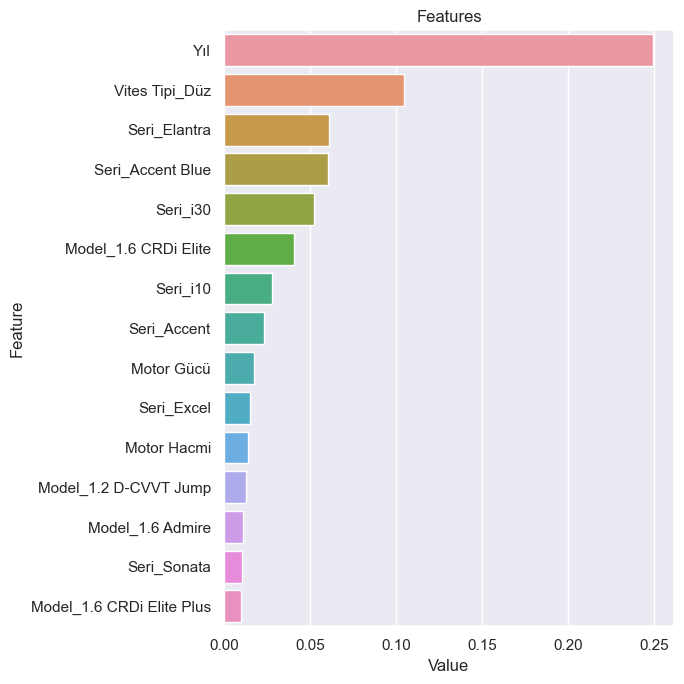

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)